### QML 3a.  Variational Quantum Classifier (VQCs) or Quantum Neural Networks (QNNs)
The goal is to find a function $f$ with parameters $\theta$ that maps a data vector / image $\vec{x}$ to the correct category: $f_\theta(\vec{x}) \rightarrow \pm1$. This will be accomplished using a VQC with few layers that can be identified by their distinct purposes:

$$
f_\theta(\vec{x}) = \langle 0|U^{\dagger}(\vec{x})W^\dagger(\theta)OW(\theta)U(\vec{x})|0\rangle
$$

Here, $U(\vec{x})$ is the encoding circuit, for which we have many options as seen in previous lessons. $W(\theta)$ is a variational, or trainable circuit block, and $\theta$ is the set of parameters to be trained. Those parameters will be varied by classical optimization algorithms to find the set of parameters that yields the best classification of images by the quantum circuit. This variational circuit is sometimes called the "ansatz". Finally, $O$ is some observable that will be estimated using the Estimator primitive. There is no constraint that forces the layers to come in this order, or even to be fully separate. One could have multiple variational and/or encoding layers in any order that is technically motivated.

If you are running this notebook in VS code, your environment must have the following libraries installed. If you are running this in google colab, you need to install the following libraries each time you initialize colab session.

`qiskit, qiskit-aer, qiskit-ibm-runtime, matplotlib, pylatexenc, pandas, scikit-learn`

### 1. Dataset
Let us create a toy data set with one feature and labels 1 or -1 randomaly and vizualize it

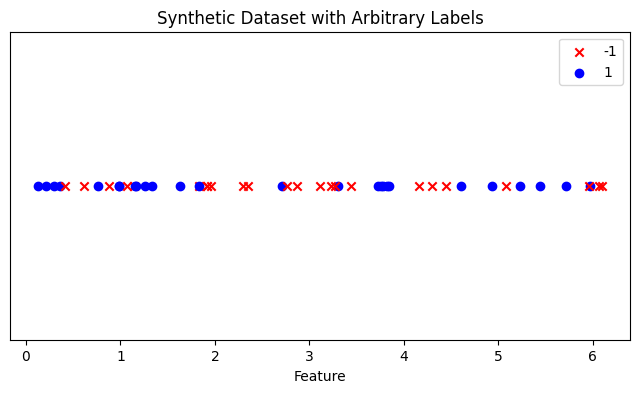

In [1]:
# Assign arbitrary labels (-1 or 1) randomly to each sample
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
X = np.random.rand(50) * 2*np.pi  # 20 random samples in range [0, 10]
y_arbitrary = np.random.choice([-1, 1], size=X.shape)

# Plot with arbitrary labels
plt.figure(figsize=(8, 4))
for xi, yi in zip(X, y_arbitrary):
    if yi == 1:
        plt.scatter(xi, 0, marker='o', color='blue', label='1' if '1' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(xi, 0, marker='x', color='red', label='-1' if '-1' not in plt.gca().get_legend_handles_labels()[1] else "")
plt.xlabel('Feature')
plt.yticks([])
plt.legend()
plt.title('Synthetic Dataset with Arbitrary Labels')
plt.show()

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_arbitrary, test_size=0.3, random_state=42)

In [3]:
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
print('test size:', test_size, ', train size:', train_size)

test size: 15 , train size: 35


### 2. U(x,$\theta$)
Let us create a simple variational circuit for data input and with a weight parameter

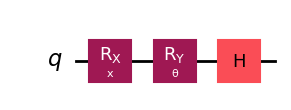

In [4]:
from qiskit.circuit import Parameter, QuantumCircuit

circuit = QuantumCircuit(1)
x = Parameter('x')
theta = Parameter('θ')
circuit.rx(x, 0)
circuit.ry(theta, 0)
circuit.h(0)


circuit.draw('mpl')

In [5]:
circuit.parameters

ParameterView([Parameter(x), Parameter(θ)])

In [6]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("Z", 1)])
observable

SparsePauliOp(['Z'],
              coeffs=[1.+0.j])

### 3. Define a function for forward pass
The function takes as input circuit, weight paramters and input data, estimator and observables and gives an array of expectation values as output

In [7]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
import numpy as np

def forward(circuit,input_params,weight_params,estimator,observable):
    num_samples = input_params.shape[0]
    weights0 = np.full_like(input_params, weight_params[0])
    params= [[inp, w0] for inp, w0 in zip(input_params, weights0)]
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
    return expectation_values

let us choose a simple loss

In [8]:
def mse_loss(predict, target):
    return ((predict - target) ** 2).mean()


### 4. Define function to compute cost for given weight parameters

In [9]:
def mse_loss_weights(weight_params):
    predictions = forward(circuit=circuit,input_params=input_params,
        weight_params=weight_params,estimator=estimator,observable=observable)

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 10 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

### 5. Training
Use a chosen optimization routine

In [10]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
import numpy as np
num_epochs = 1
num_samples = len(X_train)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

weight_params = np.random.rand() * 2 * np.pi

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    input_params = X_train
    target = y_train
    iter = 0
    res = minimize(
        mse_loss_weights, weight_params, method = "COBYLA", options={"maxiter": 100,'tol': 1e-8}
    )
    weight_params = res["x"]

Epoch: 0
Iter: 0, loss: 1.9507547147112583
Iter: 10, loss: 0.9076923845976616
Iter: 20, loss: 0.9076829267526593
Iter: 30, loss: 0.9076828874058518


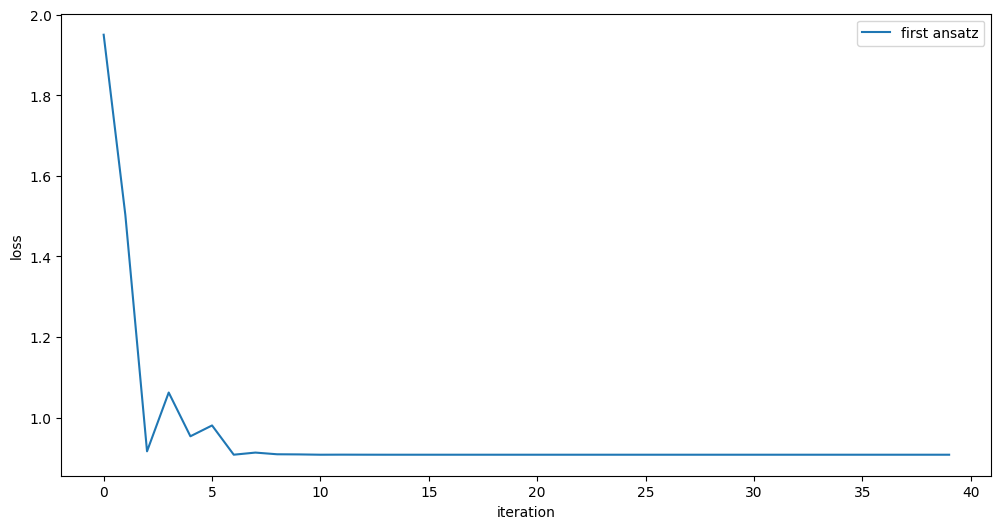

In [11]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

### 6. Training accuracy

In [12]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(X_train), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(y_train)

accuracy = accuracy_score(y_train, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.39215717 -0.41961211 -0.15872785 -0.41647204  0.17057849 -0.10931771
 -0.14032164 -0.40391424  0.41005504  0.20102995 -0.29598788 -0.02314732
 -0.41812695  0.39833997  0.23379109  0.40205187  0.41232434 -0.14124487
  0.39983635  0.268621   -0.04739354  0.35348922  0.15060223 -0.28030625
  0.30231926  0.41629853 -0.10987082 -0.38200679  0.16707687 -0.320328
  0.27994143  0.41004342  0.17437696 -0.35099966 -0.16857934]
[ 1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.]
[ 1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1
  1  1  1  1  1  1  1  1 -1  1 -1]
Train accuracy: 62.857142857142854%


### 7. Test accuracy

In [13]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_test = forward(circuit, np.array(X_test), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(y_test)

accuracy = accuracy_score(y_test, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 0.0984141  -0.39047258 -0.32755449 -0.21929731 -0.41473638 -0.40185411
  0.13054492  0.09203049  0.38522378 -0.10753834  0.20786452  0.23373825
  0.34320198 -0.33789222 -0.34169707]
[ 1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.]
[ 1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1  1  1]
Test accuracy: 60.0%


### QML 3b.  Variational Quantum Classifier (VQCs) or Quantum Neural Networks (QNNs)
The goal is to find a function $f$ with parameters $\theta$ that maps a data vector / image $\vec{x}$ to the correct category: $f_\theta(\vec{x}) \rightarrow \pm1$. This will be accomplished using a VQC with few layers that can be identified by their distinct purposes:

$$
f_\theta(\vec{x}) = \langle 0|U^{\dagger}(\vec{x})W^\dagger(\theta)OW(\theta)U(\vec{x})|0\rangle
$$

Here, $U(\vec{x})$ is the encoding circuit, for which we have many options as seen in previous lessons. $W(\theta)$ is a variational, or trainable circuit block, and $\theta$ is the set of parameters to be trained. Those parameters will be varied by classical optimization algorithms to find the set of parameters that yields the best classification of images by the quantum circuit. This variational circuit is sometimes called the "ansatz". Finally, $O$ is some observable that will be estimated using the Estimator primitive. There is no constraint that forces the layers to come in this order, or even to be fully separate. One could have multiple variational and/or encoding layers in any order that is technically motivated.

If you are running this notebook in VS code, your environment must have the following libraries installed. If you are running this in google colab, you need to install the following libraries each time you initialize colab session.

`qiskit, qiskit-aer, qiskit-ibm-runtime, matplotlib, pylatexenc, pandas, scikit-learn`

### 1. Data set. We will take Leukemia data set with 10 features
This dataset comes from the classic Golub et al. (1999) paper, where microarray gene expression data was used to distinguish Acute Myeloid Leukemia (AML) from Acute Lymphoblastic Leukemia (ALL).

Samples (n ≈ 72): Each column corresponds to one patient’s leukemia sample. There are 47 ALL samples and 25 AML samples. Each row corresponds to a gene (a probe on the microarray). The cell values are gene expression levels (typically log-transformed intensities). The data set can be downloaded from [this link](http://hastie.su.domains/CASI_files/DATA/leukemia_small.csv)

In [1]:
import pandas as pd
import numpy as np

# Load the CSV file
df_raw = pd.read_csv('leukemia_small.csv', header=None)

# Extract labels from the first row
labels = df_raw.iloc[0, :].values

# Extract data from rows 2 to 21 (index 1 to 20)
X = df_raw.iloc[1:13, :].astype(float).values
X = X.T
# Convert labels: ALL -> -1, AML -> 1
y = np.where(labels == 'ALL', -1, 1)

In [2]:
# Rescale X to be within -pi to pi
X_min = np.min(X)
X_max = np.max(X)
X_rescaled = (X - X_min) / (X_max - X_min) * (2 * np.pi) - np.pi
X = X_rescaled

In [3]:
X.shape, y.shape

((72, 12), (72,))

In [4]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
X_train, X_test, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
X_train.shape, X_test.shape, train_labels.shape, test_labels.shape

((57, 12), (15, 12), (57,), (15,))

In [6]:
X_train

array([[ 0.45801151,  0.29050772,  0.540519  ,  0.25426547,  0.94195201,
         1.68126115,  1.88882793,  1.57901433,  1.15676023,  1.10369847,
         1.22433702,  0.98483821],
       [ 0.6037405 ,  0.42144907,  0.68648556,  0.40347856,  0.49046951,
         0.20574939,  0.29417918,  0.26334827,  1.45002046,  1.39189096,
         1.5568253 ,  1.29569542],
       [ 0.35236808,  0.19558431,  0.69482814,  0.65976406,  0.47111229,
         0.13603026,  0.21883072,  0.18539955,  0.69472994,  0.61390792,
         0.670013  ,  0.5589331 ],
       [ 0.31450445,  0.16156284,  0.39677801,  0.73316706,  0.27373808,
         0.58340399,  0.20748117,  0.21512986,  0.79482805,  0.68878349,
         0.55106831,  0.62856028],
       [ 1.77871096,  0.6877804 ,  0.46424126,  0.17629119,  0.39162753,
         0.14420938,  0.22767025,  0.19454413,  0.72143888,  0.69109206,
         0.60714681,  0.75910384],
       [ 1.49691749,  0.93200252,  0.627181  ,  0.34285498,  0.56080596,
         0.18932781,  

In [7]:
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]

In [8]:
train_size, test_size

(57, 15)

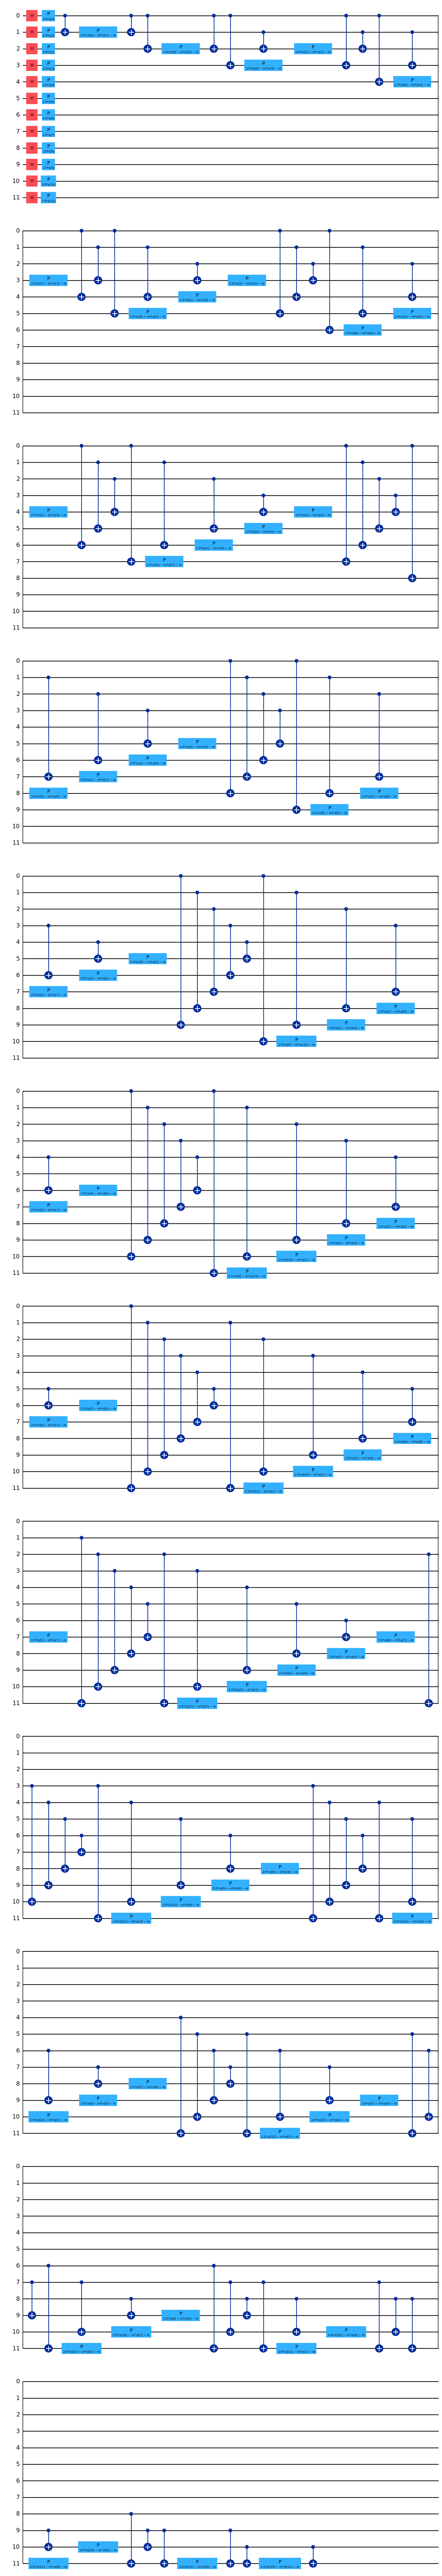

In [9]:
from qiskit.circuit.library import zz_feature_map
from qiskit.circuit.library import efficient_su2
num_features = np.shape(X_train)[1]
num_qubits = int(num_features)
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = zz_feature_map(num_qubits, reps=1,parameter_prefix="x")
feature_map.draw("mpl")

Let us first try the ansatz below. We will return to revise it, later.


3
2+ qubit depth: 1


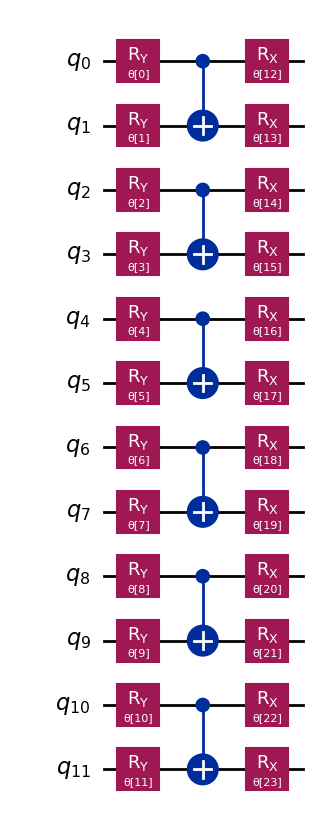

In [10]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

size = num_qubits
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0, 1],[2,3],[4,5],[6,7],[8,9],[10,11]]
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Draw the circuit
qnn_circuit.draw("mpl")

With the data encoding and variational circuit prepared, we can combine them to form our full ansatz. In this case, the components of our quantum circuit are quite analogous to those in neural networks, with $U(\vec{x})$ being most similar to the layer that loads input values from the image, and $W(\theta)$ being like the layer of variable "weights". Since this analogy holds in this case, we are adopting "qnn" in some of our naming conventions; but this analogy should not be limiting in your exploration of VQCs.



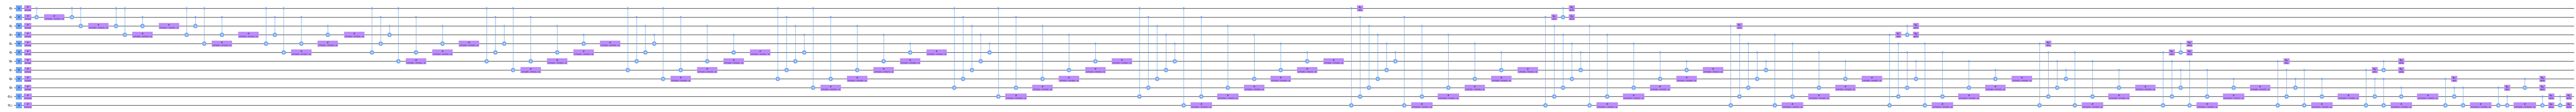

In [11]:
# QNN ansatz
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Display the circuit
full_circuit.draw("mpl", style="clifford", fold=-1)

We must now define an observable, so we can use it in our cost function. We will obtain an expectation value for this observable using Estimator. If we have selected a good, problem-motivated ansatz, then each qubit will contain information relevant to classification.  There is nothing unique about choosing $Z$, but it is well motivated:

*   This is a binary classification task, and a measurement of $Z$ can yield two possible outcomes.
*   The eigenvalues of $Z$ ($\pm 1$) are reasonably well separated, and result in an estimator outcome in interval \[-1, +1], where 0 can simply be used as a cutoff value.
*   It is straightforward to measure in Pauli Z basis with no extra gate overhead.

So, Z is a very natural choice.

In [12]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

We have our quantum circuit and the observable we want to estimate. Now we need a few things in order to run and optimize this circuit. First, we need a function to run a forward pass. Note that the function below takes in the `input_params` and `weight_params` separately. The former is the set of static parameters describing the data in an image, and the latter is the set of variable parameters to be optimized.

In [13]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator


def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.

    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.

    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs

    return expectation_values

### Loss function

Next, we need a loss function to calculate the difference between the predicted and calculated values of the labels. The function will take in the labels predicted by the algorithm and the correct labels and return the mean squared difference. There any many different loss functions. Here, MSE is an example that we chose.

In [14]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

Let us also define a slightly different loss function that is a function of the variable parameters (weights), for use by the classical optimizer. This function only takes the ansatz parameters as input; other variables for the forward pass and the loss are set as global parameters. The optimizer will train the model by sampling different weights and attempting to lower the output of the cost/loss function.

In [15]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

### Loop over the dataset in batches and epochs

We first implement the full algorithm using a simulator for cursory debugging and for estimates of error. We can now go over the entire dataset in batches in desired number of epochs to train our quantum neural network.

In [16]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize

batch_size = 64
num_epochs = 1
num_samples = len(X_train)

# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        X_train_batch = np.array(X_train[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = X_train_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method = "COBYLA", options={"maxiter": 200}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 1.0046851439292401
Iter: 50, loss: 0.9782633203069423
Iter: 100, loss: 0.9733701121257734
Iter: 150, loss: 0.9708617135197166


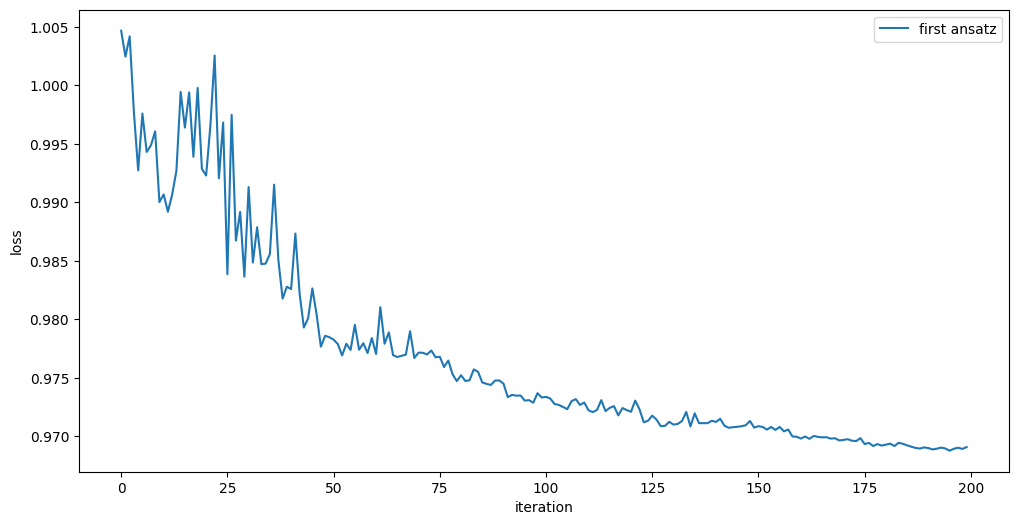

In [17]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

### Testing and accuracy

We now interpret the results from training. We first test the training accuracy over the training set.

In [18]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(X_train), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.00441001  0.01294641  0.00880493 -0.01544051 -0.00536691  0.01062999
 -0.01587556  0.02187765 -0.00052571  0.01708408 -0.03186958 -0.00040414
 -0.00233589  0.00076247 -0.02579264 -0.03315271  0.00187228 -0.02101548
 -0.01680489 -0.00078841 -0.01563934  0.04192872 -0.00341416 -0.0013394
 -0.00206518 -0.00733512  0.02468589 -0.01489461  0.01733261 -0.02203426
  0.0145562  -0.01016477 -0.03910617  0.03139786 -0.03107993  0.00521915
 -0.0154558   0.0146408   0.02072393  0.01068557 -0.0303091   0.07720142
 -0.02941213  0.02943683  0.01528062  0.02025132  0.00408789 -0.02142423
  0.00066343  0.04613192 -0.02639047 -0.0335436  -0.02268639 -0.01522316
  0.03551511 -0.00221333  0.03107507]
[ 1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1. -1. -1.  1. -1.
 -1. -1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.
 -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.
  1. -1.  1.]
[-1  1  1  1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1


and the accuracy on the test set is

In [19]:
pred_test = forward(circuit, np.array(X_test), res["x"], estimator, observable)


print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 0.02148731  0.01879924  0.0183998   0.00664569 -0.01782093  0.02204335
  0.0159648   0.01585477 -0.00993315  0.00353352 -0.00538074 -0.02541663
  0.01081736 -0.00794956 -0.00291702]
[ 1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.]
[-1  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1]
Test accuracy: 46.666666666666664%


The notebook is based on materials from various sources including  [IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning). However, it has been significantly modified. The syntax is according to qiskit version 2.3.

Please cite/acknowledge my work when you use this notebook. Thanks. M. Faryad. [github/muf18](github.com/muf148)

### QML 4b. QSVM for Leukemia Data
Quantum vs Classical SVM for Leukemia data of 72 patients

This dataset comes from the classic Golub et al. (1999) paper, where microarray gene expression data was used to distinguish Acute Myeloid Leukemia (AML) from Acute Lymphoblastic Leukemia (ALL).

Samples (n ≈ 72): Each column corresponds to one patient’s leukemia sample. There are 47 ALL samples and 25 AML samples. Each row corresponds to a gene (a probe on the microarray). The cell values are gene expression levels (typically log-transformed intensities). The data set can be downloaded from [this link](http://hastie.su.domains/CASI_files/DATA/leukemia_small.csv)


If you are running this notebook in VS code, your environment must have the following libraries installed. If you are running this in google colab, you need to install the following libraries each time you initialize colab session.

`qiskit, qiskit-aer, qiskit-ibm-runtime, matplotlib, pylatexenc, pandas, scikit-learn`

### Step 1. Data import and preprocessing
Import the data and read a desired number of features, instead of all the features.

In [1]:
import pandas as pd
import numpy as np

# Load the CSV file
df_raw = pd.read_csv('leukemia_small.csv', header=None)

# Extract labels from the first row
labels = df_raw.iloc[0, :].values

# Extract data from rows 2 to 21 (index 1 to 20)
X = df_raw.iloc[1:11, :].astype(float).values
X = X.T
# Convert labels: ALL -> -1, AML -> 1
y = np.where(labels == 'ALL', -1, 1)
print('X.shape = ', X.shape, ', y.shape = ',y.shape)

X.shape =  (72, 10) , y.shape =  (72,)


In [2]:
# Rescale X to be within -pi to pi
X_min = np.min(X)
X_max = np.max(X)
X_rescaled = (X - X_min) / (X_max - X_min) * 2*(np.pi)
X = X_rescaled

### Step 2. Split data into test and training set

In [3]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
X_train, X_test, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('X_train.shape = ', X_train.shape, ', X_test.shape = ', X_test.shape)

Bad pipe message: %s [b' 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Sa']
Bad pipe message: %s [b'ri/537.36\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/', b'ng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nA']
Bad pipe message: %s [b'ept-Language: en-US,en;q=0.9,ro;q=0.8\r\nConnection: keep-alive\r\nReferer: https://studio.firebase.go', b'le.com/\r\nSec-Ch-Ua: "Google Chrome";v="141", "Not?A_Brand";v="8", "Chromium";v="141"\r\nSec-Ch-Ua-Arch: "x86"\r\nS', b'-Ch-Ua-Bitness: "64"\r\nSec-Ch-Ua-Form-Factors: "Desktop"\r\nSec-Ch-Ua-Full-Version: "141.0.7390.66"\r\nSe', b'Ch-Ua-Full-Version-List: "Google Chrome";v="141.0.7390.66", "Not?A_Brand";v="8.0.0.0", "Chromium";', b'"141.0.7390.66"\r\nSec-Ch-Ua-Mobile: ?0\r\nSec-Ch-Ua-Model: ""\r\nSec-Ch-Ua-Platform: "Windows"\r\nSec-Ch-Ua-Platform-Version', b'"10.0.0"\r\nSec-Ch-Ua-Wow64: ?0\r\nSec-Fetch-Dest: iframe\r\nSe']

X_train.shape =  (57, 10) , X_test.shape =  (15, 10)


### Step 3. Feature Map
Design an appropriate kernel circuit containing two parts. One part has trainable weights and the other part has feature encoding. We will use a custom feature map.

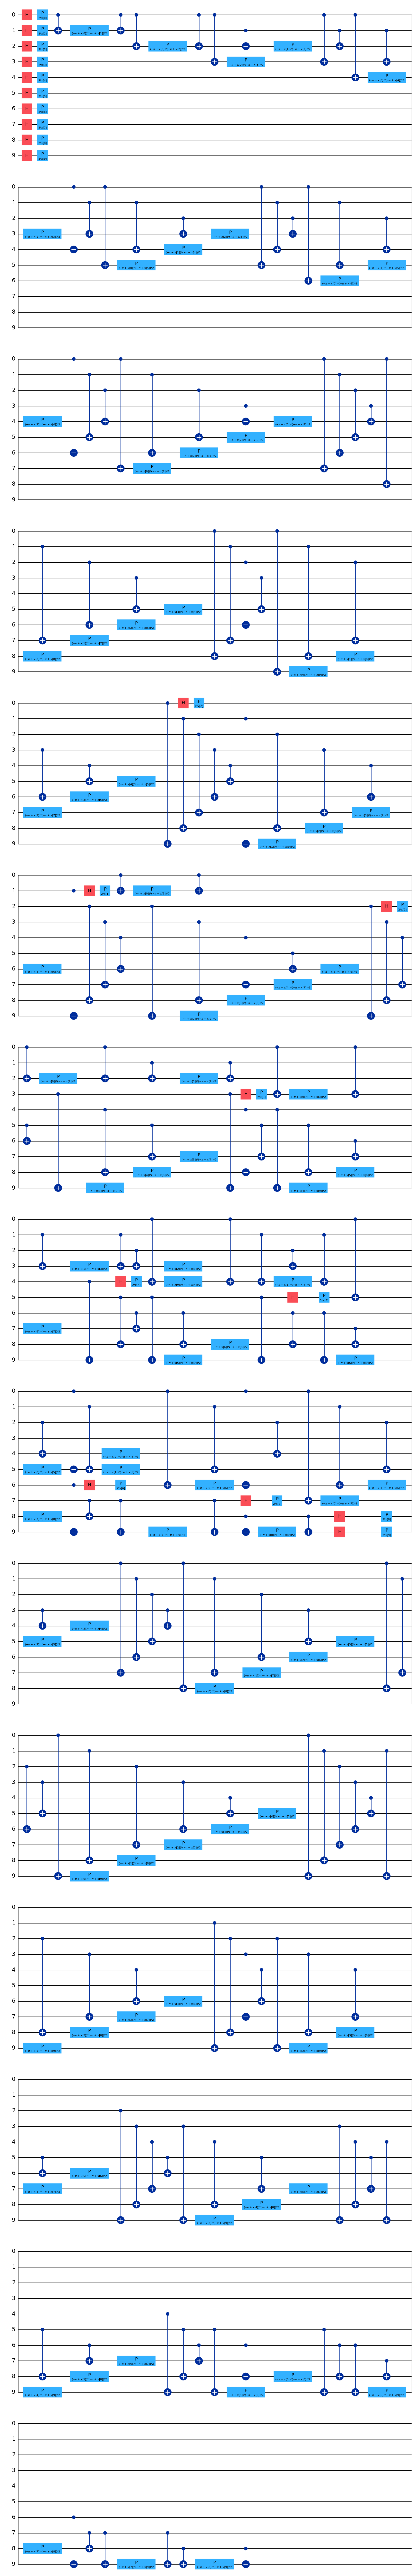

In [4]:
from qiskit.circuit.library import zz_feature_map
from qiskit.circuit.library import efficient_su2
num_features = np.shape(X_train)[1]
num_qubits = int(num_features)
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
fm = zz_feature_map(num_qubits, reps=2,parameter_prefix="x")
fm.draw("mpl")

### Step 4. Kernel and Test matrices
We do not need to optimize for the simulator and we directly run the loop over the whole dataset to compute all kernel etnries 1. For training matrix, we compute inner product between each of the example with every other example, and just put 1 for the inner product with itself. 2. For test matrix, we compute the inner product of every example in the test set with every example in the training set.

In [5]:
# Empty kernel matrix
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

In [6]:
# To use a simulator
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import unitary_overlap
 
num_shots = 10000

sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")

Bad pipe message: %s [b' 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Sa']
Bad pipe message: %s [b'ri/537.36\r\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/', b'ng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nA']
Bad pipe message: %s [b'ept-Language: en-US,en;q=0.9,ro;q=0.8\r\nConnection: keep-alive\r\nReferer: https://studio.firebase.go', b'le.com/\r\nSec-Ch-Ua: "Google Chrome";v="141", "Not?A_Brand";v="8", "Chromium";v="141"\r\nSec-Ch-Ua-Arch: "x86"\r\nS', b'-Ch-Ua-Bitness: "64"\r\nSec-Ch-Ua-Form-Factors: "Desktop"\r\nSec-Ch-Ua-Full-Version: "141.0.7390.66"\r\nSe', b'Ch-Ua-Full-Version-List: "Google Chrome";v="141.0.7390.66", "Not?A_Brand";v="8.0.0.0", "Chromium";', b'"141.0.7390.66"\r\nSec-Ch-Ua-Mobile: ?0\r\nSec-Ch-Ua-Model: ""\r\nSec-Ch-Ua-Platform: "Windows"\r\nSec-Ch-Ua-Platform-Version', b'"10.0.0"\r\nSec-Ch-Ua-Wow64: ?0\r\nSec-Fetch-Dest: iframe\r\nSe']

training done
test matrix done


Let us just visualize the kernel and test matrices

Text(0.5, 1.0, 'test matrix')

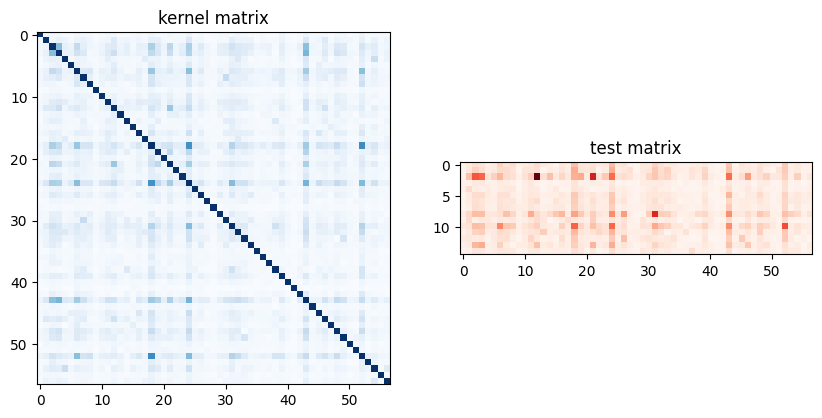

In [7]:
# Visualisation Imports
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(kernel_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("kernel matrix")

axs[1].imshow(np.asmatrix(test_matrix), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("test matrix")

### Step 3. Quantum SVM
We can now use the kernel matrix in the support vector machine class in sklearn and train it to build the statevector classifier SVC

In [8]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_train_kernel = qml_svc.score(kernel_matrix, train_labels)
print(f"Quantum SVC classification training accuracy: {qml_score_train_kernel}")
qml_score_test_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Quantum SVC classification test accuracy: {qml_score_test_kernel}")

Quantum SVC classification training accuracy: 1.0
Quantum SVC classification test accuracy: 0.6666666666666666


### Step 6. Classical SVM for comparison
To compare with classical SVM, let use the same dataset for a classical SVM.

In [9]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train, train_labels)  # suppress printing the return value
train_score_c = svc.score(X_train, train_labels)
test_score_c = svc.score(X_test, test_labels)


print(f"Classical SVC training accuracy: {train_score_c:.2f}")
print(f"Classical SVC test accuracy:     {test_score_c:.2f}")

Classical SVC training accuracy: 0.68
Classical SVC test accuracy:     0.67


The notebook is based on materials from various sources including  [IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning). However, it has been significantly modified. The syntax is according to qiskit version 2.3.

Please cite/acknowledge my work when you use this notebook. Thanks. M. Faryad. [github/muf18](github.com/muf148)